# Final Project: Part I
***

## Problem Statement:

Apache NiFi is an application which supports the automation of data processing and exchange (or flow) between systems. Its architecture is based on concepts from flow-based programming where operations on data are performed
in "black-box" processes which are connected via queues (called connections), allowing data to flow from one function to the next until it lands in it's final destination.  The goal for optimal flow design is to have data enter and exit the flow
as quickly as possible; however that could be hampered by many factors including the size data, the speed of the individual processors, the size of the queues holding data, or memory available to the cluster.

[<img src="http://nifi.apache.org/assets/images/flow.png" style="float: right; margin: 20px; height: 200px">](http://nifi.apache.org/assets/images/flow.png)

Like most applications, running out of memory can be extremely disruptive and difficult to detect before runtime. NiFi is very susceptible to this given it is a dynamic framework built to allow users to configure and process hundreds of data flow use cases; 
many which cannot be anticipated in testing.  NiFi administrators understand the importance of creating their flows to be as performant and efficient as possible however there may be periodic bursts that might require more resources than what's considered normal.
It is in these instances where predicting required resources in advance would be critical to preventing disruption due memory related exceptions.    

Using metrics captured from a NiFi cluster the main goal of this exercise is to predict the amount of memory needed for the flow deployed (JVM Heap Used).

***
## Model Targets and Features:

Target Variable: JVM Heap Used

Feature set: Active Threads, Bytes Received Last 5 Minutes, JVM Non-Heap Usage, JVM Thread Count, JVM Thread State Runnable, Load Average 1 Minute


***
## Goals and Success Metrics:
The goal is to be able to predict with reasonable the amount of memory required in order to anticipate or prevent out of memory exceptions which would be disruptive to data flows. This prediction can be used to help inform operators or platforms that run NiFi when to scale it up for additional resources based on anticipated memory requirements.

***
## Risks and Limitations:

- Prediction would be specific to the flow deployed and model may need to be updated if deployed flow configuration is altered.



***
# Getting the datasets ready

### Import the dataset

In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
# Import the 1 week of data from csv (extracted from prometheus database)
filepath = 'assets/nifi_prometheus_metrics.csv'
nifi_metrics = pd.read_csv(filepath)

In [3]:
nifi_metrics.head()

,time,id,ActiveThreads:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,BytesQueued:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,BytesReadLast5Minutes:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,BytesReceivedLast5Minutes:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,BytesSentLast5Minutes:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,BytesWrittenLast5Minutes:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,FlowFilesQueued:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,FlowFilesReceivedLast5Minutes:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,...,jvmheap_used:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,jvmnon_heap_usage:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,jvmthread_count:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,jvmthread_statesblocked:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,jvmthread_statesrunnable:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,jvmthread_statesterminated:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,jvmthread_statestimed_waiting:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,jvmuptime:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,loadAverage1min:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null,timestamp:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null
0,2019-07-20 18:15:00,pushgateway_pushgateway:9091,3.0,0.0,45674.0,22837.0,0.0,143225.0,0.0,131.0,...,460128544.0,-242551416.0,83.0,0.0,15.0,0.0,49.0,1896.0,3.144043,1.563572e+12
1,2019-07-20 18:16:00,pushgateway_pushgateway:9091,3.0,0.0,45674.0,22837.0,0.0,143225.0,0.0,131.0,...,460128544.0,-242551416.0,83.0,0.0,15.0,0.0,49.0,1896.0,3.144043,1.563572e+12
2,2019-07-20 18:17:00,pushgateway_pushgateway:9091,3.0,0.0,45674.0,22837.0,0.0,143225.0,0.0,131.0,...,460128544.0,-242551416.0,83.0,0.0,15.0,0.0,49.0,1896.0,3.144043,1.563572e+12
3,2019-07-20 18:18:00,pushgateway_pushgateway:9091,3.0,0.0,45674.0,22837.0,0.0,143225.0,0.0,131.0,...,460128544.0,-242551416.0,83.0,0.0,15.0,0.0,49.0,1896.0,3.144043,1.563572e+12
4,2019-07-20 18:19:00,pushgateway_pushgateway:9091,3.0,0.0,45674.0,22837.0,0.0,143225.0,0.0,131.0,...,46012

In [4]:
# We have 3849 rows and 27 columns
nifi_metrics.shape

(3849, 27)

### Massage the data

In [5]:
# Check columns
nifi_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3849 entries, 0 to 3848
Data columns (total 27 columns):
time                                                                                                                                                                                         3849 non-null object
id                                                                                                                                                                                           3849 non-null object
ActiveThreads:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null                    3849 non-null float64
BytesQueued:appid_nifi_exported_job_b25c8d04-016a-1000-b96f-d81944e42aa7_hostname_hw13535_instanceid_b25c8d04-016a-1000-b96f-d81944e42aa7_jvmgcruns_null_jvmgctime_null                      3849 non-null float64
BytesReadLast5Minutes:appid_nifi_exported_job_b25c8

In [6]:
# Remove unused id (represents push gateway job to server) 
nifi_metrics = nifi_metrics.drop('id',axis=1)

# Clean up  column names (they include more data than necessary)
updated_columns = [labels.split(':')[0] for labels in nifi_metrics.columns.values]
updated_columns = np.array(updated_columns)
nifi_metrics.columns=updated_columns

In [7]:
# Set indices to time column and remote duplicate timestamp column
nifi_metrics = nifi_metrics.set_index('time')
nifi_metrics = nifi_metrics.drop(['timestamp'],axis=1)

In [8]:
# Cleaned up column names
nifi_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3849 entries, 2019-07-20 18:15:00 to 2019-07-27 17:00:00
Data columns (total 24 columns):
ActiveThreads                    3849 non-null float64
BytesQueued                      3849 non-null float64
BytesReadLast5Minutes            3849 non-null float64
BytesReceivedLast5Minutes        3849 non-null float64
BytesSentLast5Minutes            3849 non-null float64
BytesWrittenLast5Minutes         3849 non-null float64
FlowFilesQueued                  3849 non-null float64
FlowFilesReceivedLast5Minutes    3849 non-null float64
FlowFilesSentLast5Minutes        3849 non-null float64
TotalTaskDurationNanoSeconds     3849 non-null float64
TotalTaskDurationSeconds         3849 non-null float64
availableCores                   3849 non-null float64
jvmdaemon_thread_count           3849 non-null float64
jvmfile_descriptor_usage         3849 non-null float64
jvmheap_usage                    3849 non-null float64
jvmheap_used                     3849 no

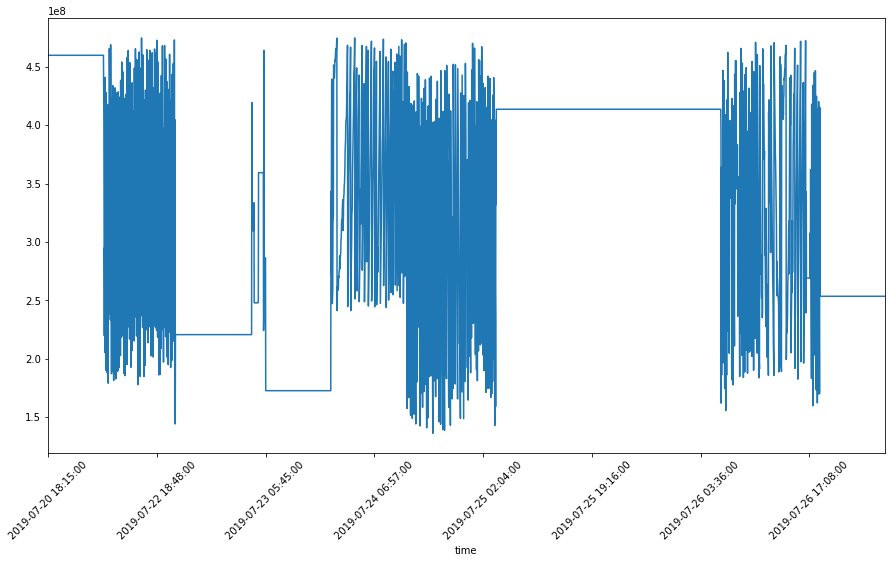

In [29]:
# Check some trends by time, JVM Used in Bytes
ax = nifi_metrics.loc[:,'jvmheap_used'].plot(figsize=(15,8),rot=45);

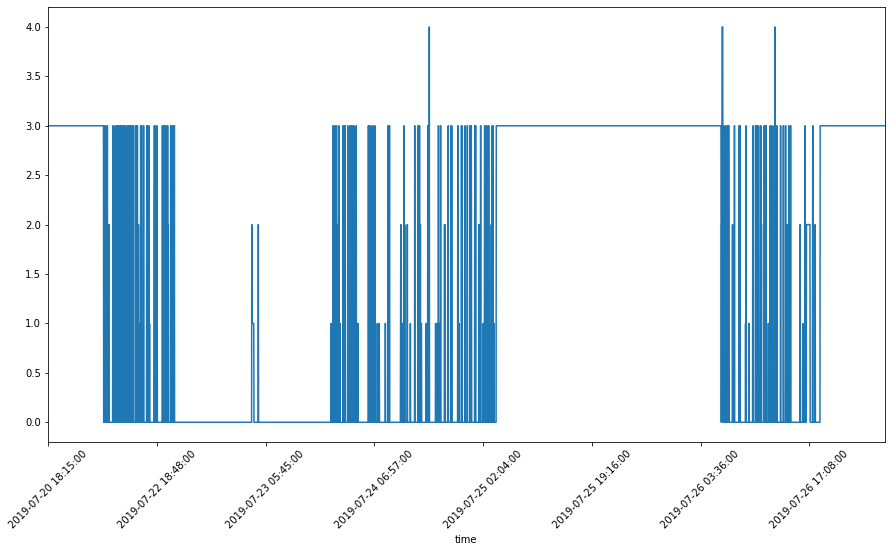

In [40]:
#Look at trend for Active NiFi Threads by datetime
ax = nifi_metrics.loc[:,'ActiveThreads'].plot(figsize=(15,8),rot=45);

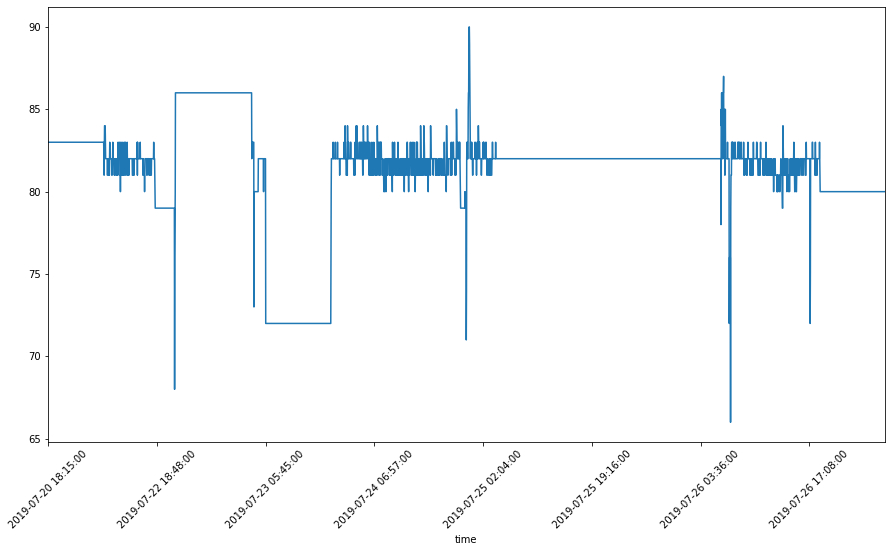

In [28]:
#JVM Thread Count
ax = nifi_metrics.loc[:,'jvmthread_count'].plot(figsize=(15,8),rot=45);

### Profile the data

In [14]:
nifi_metrics.describe()

,ActiveThreads,BytesQueued,BytesReadLast5Minutes,BytesReceivedLast5Minutes,BytesSentLast5Minutes,BytesWrittenLast5Minutes,FlowFilesQueued,FlowFilesReceivedLast5Minutes,FlowFilesSentLast5Minutes,TotalTaskDurationNanoSeconds,...,jvmheap_usage,jvmheap_used,jvmnon_heap_usage,jvmthread_count,jvmthread_statesblocked,jvmthread_statesrunnable,jvmthread_statesterminated,jvmthread_statestimed_waiting,jvmuptime,loadAverage1min
count,3849.000000,3.849000e+03,3.849000e+03,3849.000000,3849.0,3.849000e+03,3849.000000,3849.000000,3849.0,3.849000e+03,...,3849.000000,3.849000e+03,3.849000e+03,3849.000000,3849.000000,3849.000000,3849.0,3849.000000,3849.000000,3849.000000
mean,1.391270,2.914680e+04,8.472894e+05,354102.388413,0.0,3.322487e+06,18.048064,1076.223175,0.0,4.197794e+09,...,0.615781,3.305946e+08,-2.497209e+08,81.320083,0.004157,14.330735,0.0,48.954534,7811.052741,3.645105
std,1.479832,3.018292e+05,2.040324e+06,142899.506159,0.0,8.363977e+06,401.766612,1290.817287,0.0,1.101747e+10,...,0.181755,9.757928e+07,1.799513e+07,3.176367,0.136725,0.840437,0.0,2.362929,7960.590626,1.526329
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,1.000000,0.0,9.476633e+07,...,0.253655,1.361799e+08,-2.675632e+08,66.000000,0.000000,13.000000,0.0,41.000000,36.000000,1.158203
25%,0.000000,0.000000e+00,5.602620e+05,279356.000000,0.0,2.158366e+06,0.000000,775.000000,0.0,3.519467e+09,...,0.454416,2.439627e+08,-2.629978e+08,81.000000,0.000000,14.000000,0.0,48.000000,1896.000000,2.850586
50%,0.000000,0.000000e+00,8.446300e+05,421687.000000,0.0,3.244590e+06,0.000000,1176.000000,0.0,3.758088e+09,...,0.666453,3.577992e+08,-2.574555e+08,82.000000,0.000000,14.000000,0.0,48.000000,8299.000000,3.703613
75%,3.000000,4.886700e+04,8.746200e+05,437310.000000,0.0,3.362597e+06,10.000000,1198.000000,0.0,3.850678e+09,...,0.770939,4.138948e+08,-2.425514e+08,82.000000,0.000000,15.000000,0.0,50.000000,8299.000000,4.495605
max,4.000000,1.336886e+07,3.712177e+07,439041.000000,0.0,1.494957e+08,18264.000000,24965.000000,0.0,2.062455e+11,...,0.884783,4.750142e+08,-1.869874e+08,90.000000,7.000000,22.000000,0.0,56.000000,37325.000000,51.120605


In [15]:
#Reviewing describe data removed columns where data had no change (e.g. 0 min, max, mean)
nifi_metrics = nifi_metrics.drop(['FlowFilesSentLast5Minutes','BytesSentLast5Minutes','jvmthread_statesterminated','availableCores'],axis=1)
nifi_metrics.columns

Index(['ActiveThreads', 'BytesQueued', 'BytesReadLast5Minutes',
       'BytesReceivedLast5Minutes', 'BytesWrittenLast5Minutes',
       'FlowFilesQueued', 'FlowFilesReceivedLast5Minutes',
       'TotalTaskDurationNanoSeconds', 'TotalTaskDurationSeconds',
       'jvmdaemon_thread_count', 'jvmfile_descriptor_usage', 'jvmheap_usage',
       'jvmheap_used', 'jvmnon_heap_usage', 'jvmthread_count',
       'jvmthread_statesblocked', 'jvmthread_statesrunnable',
       'jvmthread_statestimed_waiting', 'jvmuptime', 'loadAverage1min'],
      dtype='object')

### Evaluate feature correlation with the target (jvmheap_used)

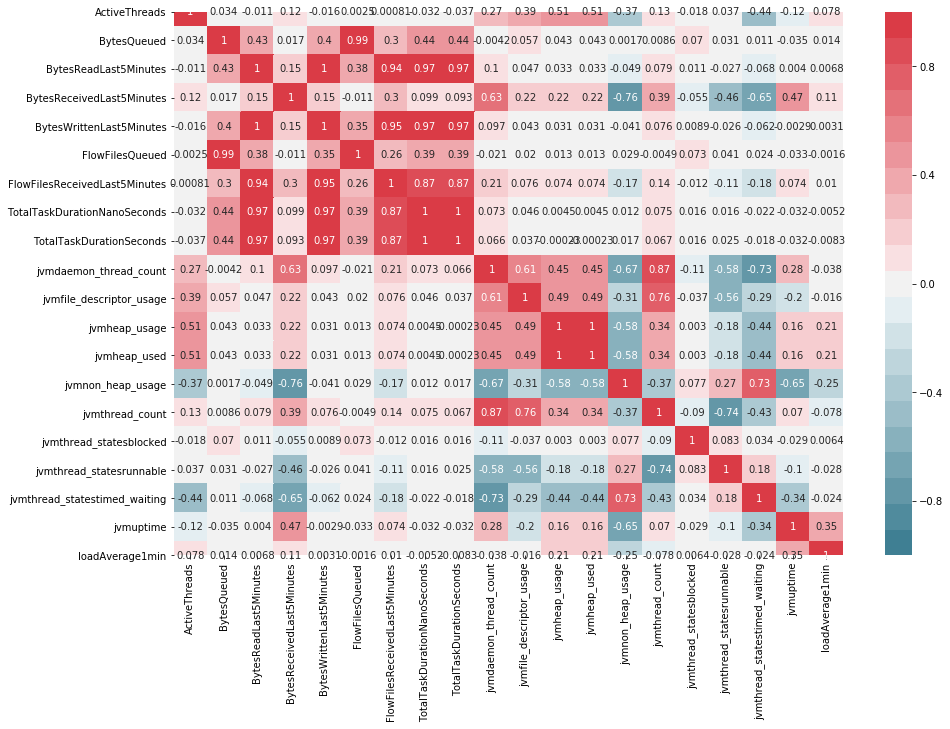

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize correlation matrix in Seaborn using a heat map.
metrics_corr = nifi_metrics.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(metrics_corr,
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(220, 10, n=21),
            annot=True,
            ax=ax,
           );


Looking at matrix above the following columns appear to have reasonable correlation with jvmheap_used without too much correlation with each other: 
'ActiveThreads', 'BytesReceivedLast5Minutes', 'jvmnon_heap_usage', 'jvmthread_count', 'jvmthread_statesrunnable','loadAverage1min'

In [35]:
# Select features and target list
feature_cols = ['ActiveThreads', 'BytesReceivedLast5Minutes', 'jvmnon_heap_usage', 'jvmthread_count', 'jvmthread_statesrunnable','loadAverage1min']
target_col = ['jvmheap_used']

In [36]:
# Create feature and target dataframes

X = nifi_metrics.loc[:, feature_cols]
y = nifi_metrics.loc[:, target_col]

In [37]:
print(X.head())
print(y.head())

                     ActiveThreads  BytesReceivedLast5Minutes  \
time                                                            
2019-07-20 18:15:00            3.0                    22837.0   
2019-07-20 18:16:00            3.0                    22837.0   
2019-07-20 18:17:00            3.0                    22837.0   
2019-07-20 18:18:00            3.0                    22837.0   
2019-07-20 18:19:00            3.0                    22837.0   

                     jvmnon_heap_usage  jvmthread_count  \
time                                                      
2019-07-20 18:15:00       -242551416.0             83.0   
2019-07-20 18:16:00       -242551416.0             83.0   
2019-07-20 18:17:00       -242551416.0             83.0   
2019-07-20 18:18:00       -242551416.0             83.0   
2019-07-20 18:19:00       -242551416.0             83.0   

                     jvmthread_statesrunnable  loadAverage1min  
time                                                            
